In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [37]:
# Load the dataset
data = pd.read_csv('diabetes-2-1 (1).csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
# Exploring the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [39]:
# Replace 0 values with NaN in specified columns
cols_to_replace_zeroes = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[cols_to_replace_zeroes] = data[cols_to_replace_zeroes].replace(0, np.nan)

# Impute NaN values using the mean for each column
for col in cols_to_replace_zeroes:
    data[col] = data[col].fillna(data[col].mean())

# Consider outlier handling here (e.g., using IQR or Z-score methods)
# Example: Removing outliers based on IQR for BMI
Q1 = data['BMI'].quantile(0.25)
Q3 = data['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['BMI'] >= lower_bound) & (data['BMI'] <= upper_bound)]
#---------------------- End of Cleaning Section ----------------------

In [40]:
# Define features and target
X = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = data['Outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [41]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='rbf')
}

# Store predictions and metrics for each model
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[model_name] = {
        "y_pred": y_pred,
        "accuracy": accuracy_score(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

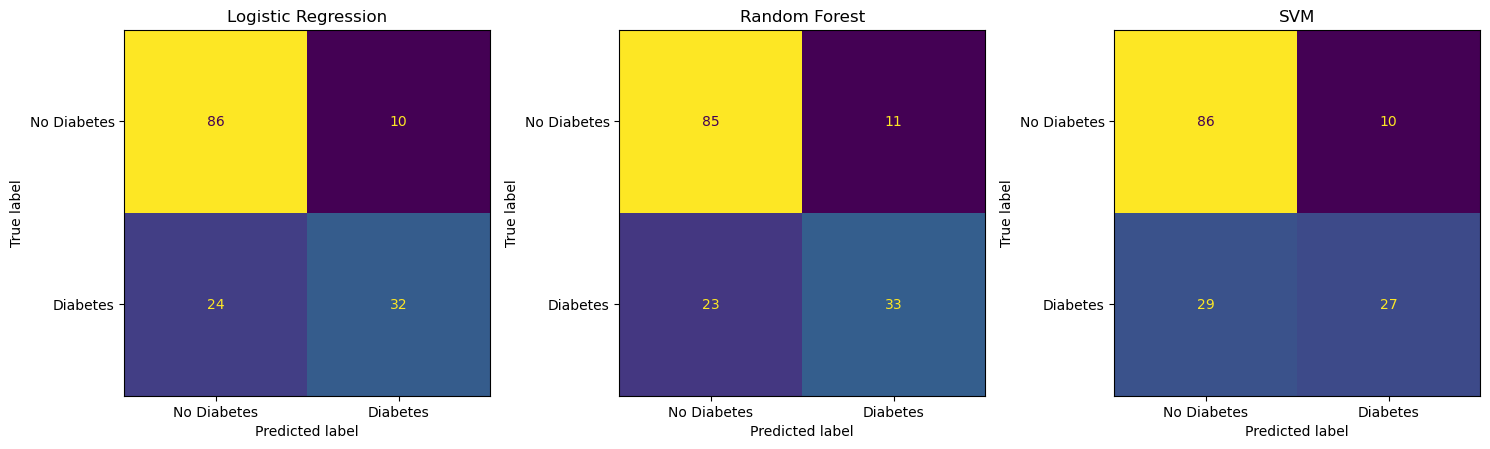

In [45]:

# Plot confusion matrices for each model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (model_name, result) in zip(axes, results.items()):
    cm = result["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(model_name)

plt.tight_layout()
plt.show()


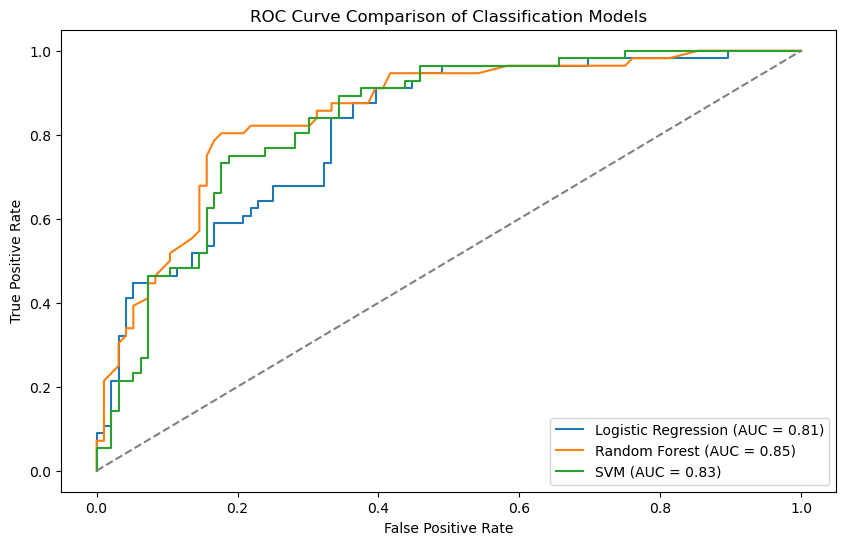

In [51]:
# Generate ROC curve for each model
plt.figure(figsize=(10, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Check if model supports probability prediction
        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    else:  
        y_prob = model.decision_function(X_test)  # Use decision function for SVM
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Classification Models")
plt.legend(loc="lower right")
plt.show()